In [2]:
import numpy as np
import matplotlib.pyplot as plt

Data Model: data = signal+noise    
signal           = Ax+mu  
x is a random number drawn from a standard normal distribution, < x >=0, <x^2>=1    
the noise is Gaussian with mean =< noise >=0 and variance = < ( x-< x >)**2 >=sigma^2

A and mu depend on the parameters a,b. a and b are the parameters we are interested in inferring.

In [3]:
#get A as a function of a,b
def get_A(a,b,dim=1):
    A = a**2*np.ones((dim,dim))+b/2.
    return A

In [4]:
#get mu as a function of a,b
def get_mu(a,b, dim=1):
    mu = a**3/np.exp(b)*np.ones(dim)
    return mu

Fiducial Parameters (this is the underlying truth)

In [5]:
a_0=2; b_0=0.5

In [6]:
A_0  = get_A(a_0,b_0)
mu_0 = get_mu(a_0, b_0)

Noise level

In [7]:
sigma = 0.1

In [8]:
def generate_noise(sigma,dim=1,nsamples=100,rand_seed=None):
    np.random.seed(rand_seed)
    noise = np.random.randn(nsamples,dim)*sigma
    return noise

In [9]:
def generate_signal(A,mu,sigma,dim=1, nsamples=100,rand_seed=None):
    np.random.seed(rand_seed)
    x      = np.random.randn(nsamples,dim)
    signal = A*x+mu
    return signal

In [10]:
def generate_data(A,mu,sigma,dim,nsamples,rand_seed=None):
    
    signal = generate_signal(A,mu,sigma,dim,nsamples,rand_seed)
    noise  = generate_noise(sigma,dim,nsamples,rand_seed)
    
    data   = signal+noise
    
    return data

fiducial data (that's the assumed truth)

In [11]:
fid_data = generate_data(A_0,mu_0,sigma,dim=1, nsamples=1000,rand_seed=None)

In [12]:
def Gaussian(x,Mu,Sigma):
    return 1/np.sqrt(np.pi*2.)/Sigma*np.exp(-0.5*(x-Mu)**2/Sigma**2)

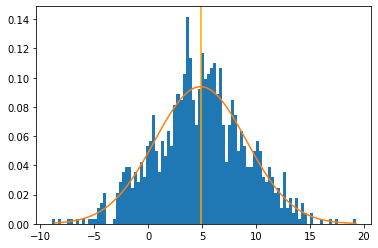

In [13]:
_, bins,_ = plt.hist(fid_data, density=True,bins=100)
plt.axvline(mu_0,color='orange')
delta = np.diff(bins) 
bins  = bins[0:-1]+delta
plt.plot(bins,np.squeeze(Gaussian(bins,mu_0,(A_0**2+sigma**2)**(0.5))))
plt.show()

#### Fit P(A|d) by Fisher Analysis

In [14]:
def get_Gaussian(mu,Sigma):
    
    def Gaussian(x):
        return 1/np.sqrt((2.*np.pi))/Sigma*np.exp(-0.5*(x-mu)**2/Sigma**2)
    
    return Gaussian

In [104]:
def get_Sigma(params):
    a,b = params
    return a**2+1

def get_mu(params):
    a,b = params
    return (b-2)**2

In [105]:
def data_probability(params,data):
    Sigma = get_Sigma(params)
    mu    = get_mu(params)
    prob  = get_Gaussian(mu, Sigma)
    return prob(data)

In [106]:
def finite_diff(params,func):
    delta_params = np.asarray(params)*0.02
    derivative = (func(params+delta_params)-func(params-delta_params))/(2*delta_params)
    return derivative

In [107]:
from functools import partial

In [108]:
def generate_data(params):
    Sigma = get_Sigma(params)
    mu    = get_mu(params)
    data  = Sigma*np.random.randn(1)+mu
    return data

In [109]:
true_params = [1.5,2]

In [110]:
data = generate_data(true_params)
print(data)
#to reprosuce my results, set data to 3.71343085

[3.71343085]


In [111]:
p_of_params = partial(data_probability, data=data)
deriv       = partial(finite_diff,func=p_of_params)

In [112]:
from scipy.optimize import fsolve, minimize

In [125]:
params_init = [1.,2.]

In [141]:
# this solver is not working well, as you can see
output= fsolve(deriv,params_init,full_output=True,maxfev=1000,xtol=1e-10)
print(output)
best_params= output[0]
print(best_params)

(array([0.68824646, 1.37649296]), {'nfev': 14, 'fjac': array([[-0.59351745,  0.80482112],
       [-0.80482112, -0.59351745]]), 'r': array([ 0.03951595, -0.08027564, -0.34883639]), 'qtf': array([2.40842233e-17, 1.38826461e-16]), 'fvec': array([-1.26024874e-16, -6.30124355e-17])}, 1, 'The solution converged.')
[0.68824646 1.37649296]


In [151]:
# here we sample the probability distribution on a grid
# (I think that's what Lister tried to do, or maybe even did?)
a_ = np.linspace(-5,5,100)
b_ = np.linspace(-2,5,100)
a_, b_ = np.meshgrid(a_,b_)
p  = p_of_params([a_,b_])


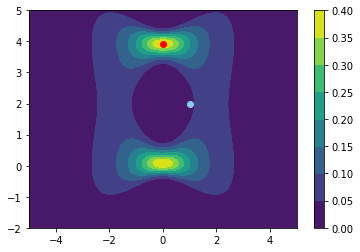

In [152]:
fig,ax=plt.subplots(1,1)
cp = ax.contourf(a_, b_, p)
plt.scatter(best_params[0],best_params[1],color='red')
plt.scatter(params_init[0],params_init[1],color='skyblue')
fig.colorbar(cp)

In [158]:
#let's switch to minimization instead. This is the Nelder-Mead algorithm
result = minimize(lambda params: -p_of_params(params),params_init, method='Nelder-Mead')
print(result)
best_params=result['x']

 final_simplex: (array([[-9.50122415e-06,  3.92703944e+00],
       [-3.71798453e-05,  3.92703253e+00],
       [ 7.78472166e-05,  3.92701819e+00]]), array([-0.39894228, -0.39894228, -0.39894228]))
           fun: -0.39894227986347475
       message: 'Optimization terminated successfully.'
          nfev: 96
           nit: 49
        status: 0
       success: True
             x: array([-9.50122415e-06,  3.92703944e+00])


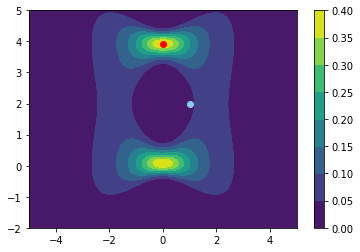

In [160]:
fig,ax=plt.subplots(1,1)
cp = ax.contourf(a_, b_, p)
plt.scatter(best_params[0],best_params[1],color='red')
plt.scatter(params_init[0],params_init[1],color='skyblue')
fig.colorbar(cp)
## -> it works very well

In [165]:
#let's try another algorithm
result = minimize(lambda params: -p_of_params(params),params_init, jac=lambda params: -deriv(params), method='L-BFGS-B')
print(result)
best_params=result['x']
#it get's stuck and tells us so

      fun: array([-0.06634841])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00071402, -0.00053392])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 44
      nit: 3
   status: 2
  success: False
        x: array([1.75177577, 2.34266029])


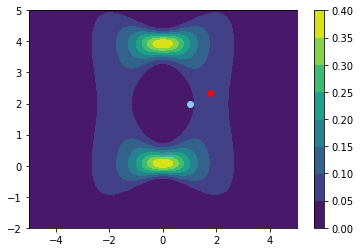

In [166]:
fig,ax=plt.subplots(1,1)
cp = ax.contourf(a_, b_, p)
plt.scatter(best_params[0],best_params[1],color='red')
plt.scatter(params_init[0],params_init[1],color='skyblue')
fig.colorbar(cp)

In [176]:
#let's try another algorithm
result = minimize(lambda params: -p_of_params(params),params_init, jac=lambda params: -deriv(params), method='Powell')
print(result)
best_params=result['x']

   direc: array([[ 0.00000000e+00,  1.00000000e+00],
       [-7.00552961e-03, -1.61121634e-05]])
     fun: array(-0.39894228)
 message: 'Optimization terminated successfully.'
    nfev: 79
     nit: 3
  status: 0
 success: True
       x: array([1.03724835e-08, 3.92702639e+00])


/home/nessa/.local/lib/python3.7/site-packages/scipy/optimize/_minimize.py:500: RuntimeWarning: Method Powell does not use gradient information (jac).
  RuntimeWarning)


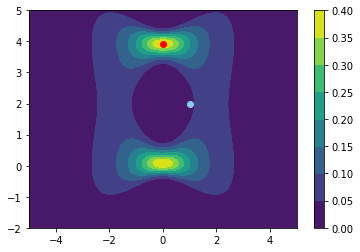

In [177]:
fig,ax=plt.subplots(1,1)
cp = ax.contourf(a_, b_, p)
plt.scatter(best_params[0],best_params[1],color='red')
plt.scatter(params_init[0],params_init[1],color='skyblue')
fig.colorbar(cp)

Can you try other algorithms? :) 
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
Some of them require a Hessian - you might already have a finite differencing function for Hessians. (See also next question)

Can you compute the Fisher information from finite differencing and plot the Gaussian that we get for P(A) from the Fisher analysis?